In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from main_numpy import NeuronModel

In [2]:
def create_2d_grid_graph(rows, columns):
    """Returns network as 2D grid graph and nodes on the periphery are connected to sink"""
    grid_graph = nx.grid_2d_graph(rows, columns)
    converted_graph = nx.convert_node_labels_to_integers(grid_graph)
    converted_graph.add_node(-1)  # Add sink node

    for node in converted_graph.nodes():
        if converted_graph.degree(node) < 4:
            converted_graph.add_edge(node, -1)  # Add edge to sink node

    return converted_graph

In [3]:
rows = 10
columns = 10

grid_network = create_2d_grid_graph(rows, columns)
grid_network_model = NeuronModel(grid_network)   
grid_network_data = np.array(grid_network_model.run(100000))  # number of steps

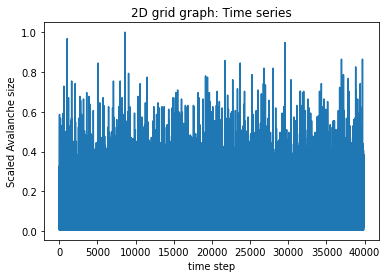

In [5]:
norm_grid_network_data = [aval_size/max(grid_network_data) for aval_size in grid_network_data] #to scale data

plt.figure()
plt.plot(norm_grid_network_data)

# Add labels and title
plt.xlabel('time step')
plt.ylabel('Scaled Avalanche size')
plt.title('2D grid graph: Time series')

# Show the plot
plt.show()   

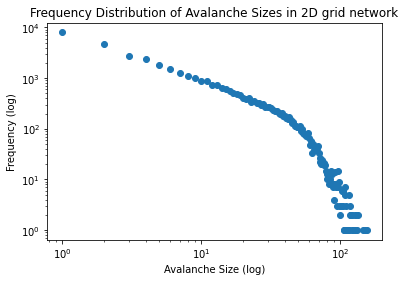

In [4]:
# Calculate the unique avalanche sizes and their frequencies
avalanche_sizes_grid, frequencies_grid = np.unique(grid_network_data, return_counts=True)

# Plot the data points on a log-log scale
plt.figure()
plt.scatter(avalanche_sizes_grid, frequencies_grid)

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Avalanche Size (log)')
plt.ylabel('Frequency (log)')
plt.title('Frequency Distribution of Avalanche Sizes in 2D grid network')

# Show the plot
plt.show()

In [6]:
grid_network_20 = create_2d_grid_graph(20, 20)
grid_network_model_20 = NeuronModel(grid_network_20)   
grid_network_data_20 = np.array(grid_network_model_20.run(50000))  # number of steps

In [7]:
grid_network_40 = create_2d_grid_graph(40, 40)
grid_network_model_40 = NeuronModel(grid_network_40)   
grid_network_data_40 = np.array(grid_network_model_40.run(50000))  # number of steps

In [8]:
grid_network_100 = create_2d_grid_graph(100, 100)
grid_network_model_100 = NeuronModel(grid_network_100)   
grid_network_data_100 = np.array(grid_network_model_100.run(50000))  # number of steps

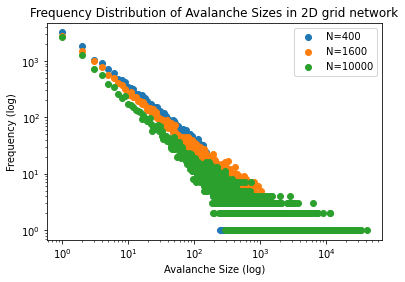

In [9]:
# Calculate the unique avalanche sizes and their frequencies
avalanche_sizes_grid_20, frequencies_grid_20 = np.unique(grid_network_data_20, return_counts=True)
avalanche_sizes_grid_40, frequencies_grid_40 = np.unique(grid_network_data_40, return_counts=True)
avalanche_sizes_grid_100, frequencies_grid_100 = np.unique(grid_network_data_100, return_counts=True)

# Plot the data points on a log-log scale
plt.figure()
plt.scatter(avalanche_sizes_grid_20, frequencies_grid_20, label="N=400")
plt.scatter(avalanche_sizes_grid_40, frequencies_grid_40, label="N=1600")
plt.scatter(avalanche_sizes_grid_100, frequencies_grid_100, label="N=10000")

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Avalanche Size (log)')
plt.ylabel('Frequency (log)')
plt.title('Frequency Distribution of Avalanche Sizes in 2D grid network')
plt.legend()

# Show the plot
plt.show()